In [1]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from FeatureEngineering import create_time_matrix
from MatchingAlgorithm import run_algorithm

### Create variables

In [29]:
orders = pd.read_csv("Simulated Data/order_data_1576.csv", dtype={'long': str, 'lat': str})
all_columns = orders.columns
service_cols = all_columns[all_columns.str.contains('service')]
orders = orders.iloc[0:23]
orders['Address'] = orders['lat'].str.cat(orders['long'], sep=',')

supply_df = pd.read_csv("Simulated Data/phleb_data_1576.csv", dtype={'home_lat': str, 'home_long': str})
phleb = supply_df
phleb = phleb.iloc[0:3]
phleb['Address'] = phleb['home_lat'].str.cat(phleb['home_long'], sep=',')

catchment = pd.read_csv("Simulated Data/catchment_data_1576.csv", dtype={'lat': str, 'long': str})
catchment['Address'] = catchment['lat'] + "," + catchment['long']

order_window = [(6 * 60, 18 * 60)] #ending depot
order_window.extend([(int(start) * 60, (int(start)+1) * 60) for start in phleb['shift_start']])
order_window.extend([(int(start) * 60, int(start+1) * 60) for start in orders['order_start']])

numPhleb = phleb.shape[0]

revenues = [1] #ending depot
revenues.extend([1 for _ in range(numPhleb)])
revenues.extend(orders['price'])

API_key = '' #INPUT YOUR OWN API KEY

#Add Catchment Area first
addresses_list = []
addresses_list.append(catchment['Address'].iloc[0])

#Phlebotomists' Starting Points first
addresses_list.extend(phleb['Address'])
#Orders' Locations
addresses_list.extend(orders['Address'])

time_matrix = create_time_matrix(addresses_list, API_key)

servicing_times = [0]
servicing_times = [0 for _ in range(numPhleb)]
servicing_times.extend(orders['duration'])

#Service-Expertise Constraints
def find_applicable_exp(row):
    args = np.empty(0)
    for val in row:
        args = np.append(args, val)
    idx = [args == 1]
    service_needs = service_cols[idx[0]]

    expertiseName = "expertise_{}".format(service_needs[0].split("_")[1])
    temp = phleb.loc[(phleb[expertiseName] == 1)]

    if len(service_needs) > 1:
        for service in service_needs[1:]:
            expertiseName = "expertise_{}".format(service.split("_")[1])
            temp = temp.loc[(temp[expertiseName] == 1)]
    
    return temp.index.to_list()

orders['Acceptable Phleb Indices'] = orders[service_cols].apply(find_applicable_exp, axis=1)
expertises = [1] #ending depot
expertises.extend([1 for _ in range(numPhleb)])
expertises.extend(orders['Acceptable Phleb Indices'])

c:\Users\XieLo\anaconda3\envs\env_dlib\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


### Running algorithm

In [30]:
# running algorithm
result = run_algorithm(time_matrix, order_window, revenues, numPhleb, servicing_times, expertises)

In [32]:
print(result)

{
  "Model": {
    "Objective Number": 2091,
    "Status": 1,
    "Total Revenue Lost": 1650,
    "Total Number of Nodes Dropped": 8,
    "Nodes Dropped": [
      4,
      5,
      7,
      9,
      19,
      22,
      25,
      26
    ],
    "Revenues Dropped": [
      250,
      150,
      150,
      300,
      350,
      100,
      50,
      300
    ],
    "Total Travel Time": 290,
    "Total Loads": 16
  },
  "Routes": [
    {
      "Phlebotomist Index": 0,
      "Printable Route": "Route for Phlebotomist 0:\nLocation 1 Start(420,420) End(420, 420) -> Slack(19, 19) -> Location 11 Start(460,460) End(525, 525) -> Slack(0, 0) -> Location 24 Start(544,544) End(564, 564) -> Slack(0, 0) -> Location 10 Start(565,565) End(610, 610) -> Slack(0, 0) -> Location 12 Start(620,620) End(665, 665) -> Slack(0, 0) -> Location 20 Start(681,681) End(726, 726) -> Slack(0, 0) -> Location 13 Start(745,745) End(770, 770) -> Slack(0, 0) -> Location 21 Start(775,775) End(795, 795) -> Slack(0, 0) -> Location

### Visualisation

In [5]:
routes = {}
for key, value in result.items():
    locations = [int(loc) for loc in re.findall(r'Location (\d+)', value)]
    routes[key] = locations
print(routes)

{0: [1, 8, 9, 15, 23, 19, 0], 1: [2, 12, 5, 25, 10, 0], 2: [3, 13, 20, 11, 26, 0]}


In [40]:
import geopandas as gpd
from shapely.geometry import Point, LineString
import plotly_express as px
import networkx as nx
import osmnx as ox
import folium
ox.config(log_console=True)

c:\Users\goshu\anaconda3\envs\ox\Lib\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


In [7]:
# load geodata
polygon = gpd.read_file("Simulation\Gurugram_sample_Polygon.geojson")

            dtname   stname stcode11 dtcode11   year_stat   SHAPE_Length  \
0            Morbi  GUJARAT       24      727  update2014  598334.202641   
1        Ahmadabad  GUJARAT       24      474      2011_c  950616.802956   
2            Anand  GUJARAT       24      482      2011_c  434665.001203   
3  Devbhumi Dwarka  GUJARAT       24      728  update2014  730297.608335   
4         Jamnagar  GUJARAT       24      477      2011_c  814332.844603   

     SHAPE_Area  OBJECTID  test  Dist_LGD  State_LGD  \
0  5.892260e+09         1   NaN       673         24   
1  8.557033e+09         2   NaN       438         24   
2  3.732902e+09         3   NaN       440         24   
3  4.869684e+09         4   NaN       674         24   
4  6.944454e+09         5   NaN       447         24   

                                            geometry  
0  POLYGON ((71.27029 23.15576, 71.26874 23.15591...  
1  POLYGON ((72.33651 23.10707, 72.33487 23.10812...  
2  POLYGON ((73.21971 22.62603, 73.21961 

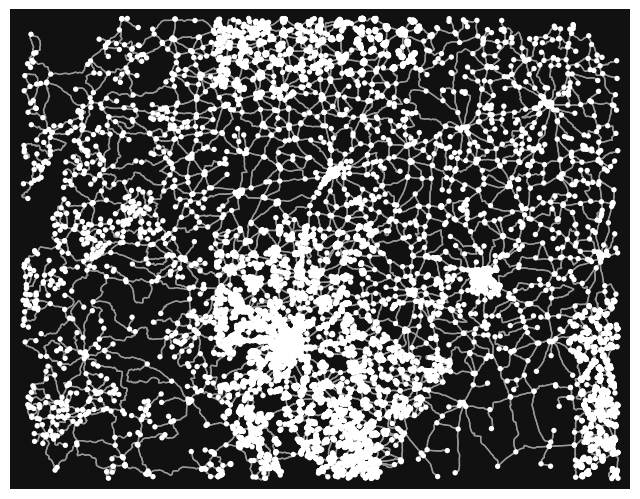

In [8]:
x_min, y_min, x_max, y_max = polygon.total_bounds
G = ox.graph_from_bbox(north=y_max, south=y_min, east=x_max, west=x_min, network_type='drive')
fig, ax = ox.plot_graph(G)

In [43]:
routes_list = []
for key, value in routes.items():
    print(f"Creating route travelled by Phlebo ID {key}...")
    last_order_index = len(value) - 2
    # iterate until last order (2nd last destination)
    for i in range(len(value)-1):
        start = addresses_list[routes[key][i]].split(',')
        end = addresses_list[routes[key][i+1]].split(',')
        start_lat, start_long = float(start[0]), float(start[1])
        end_lat, end_long = float(end[0]), float(end[1])

        start_node = ox.distance.nearest_nodes(G, Y=start_lat, X=start_long)
        end_node = ox.distance.nearest_nodes(G, Y=end_lat, X=end_long)

        route = nx.shortest_path(G, start_node, end_node, weight='distance')

        if i == 0:
            # create route map
            print(f"Map created for Phlebo ID {key}'s route")
            route_map = ox.plot_route_folium(G, route, route_linewidth=6, node_size=0)
            # create markers
            start_marker = folium.Marker(
                location=(start_lat, start_long), # only accepts coords in tuple form
                popup='Home',
                icon = folium.Icon(color='green')
            )
            end_marker = folium.Marker(
                location=(end_lat, end_long), # only accepts coords in tuple form
                popup='Home',
                icon = folium.Icon(color='blue')
            )
            # add markers 
            start_marker.add_to(route_map)
            end_marker.add_to(route_map)
        else:
            # if map has been created, add onto route map
            route_map = ox.plot_route_folium(G, route, route_linewidth=6, node_size=0, route_map=route_map)
            start_marker = folium.Marker(
                location=(start_lat, start_long), # only accepts coords in tuple form
                popup=f'Order #',
                icon = folium.Icon(color='blue')
            )
            start_marker.add_to(route_map)
            if i != last_order_index:
                end_marker = folium.Marker(
                    location=(end_lat, end_long), # only accepts coords in tuple form
                    popup=f'Order #',
                    icon = folium.Icon(color='blue')
                )
                end_marker.add_to(route_map)
            if i == last_order_index:
                end_marker = folium.Marker(
                location=(end_lat, end_long), # only accepts coords in tuple form
                popup='Catchment area',
                icon = folium.Icon(color='red')
                )
                end_marker.add_to(route_map)
                print(f"Last order for Phlebo ID {key} fulfilled")
                # display map at the end of last order
                print(f"Route travelled by Phlebo ID {key}")
                display(route_map) 

    routes_list.append(route_map)

Creating route travelled by Phlebo ID 0...
Map created for Phlebo ID 0's route
Last order for Phlebo ID 0 fulfilled
Route travelled by Phlebo ID 0


Creating route travelled by Phlebo ID 1...
Map created for Phlebo ID 1's route
Last order for Phlebo ID 1 fulfilled
Route travelled by Phlebo ID 1


Creating route travelled by Phlebo ID 2...
Map created for Phlebo ID 2's route
Last order for Phlebo ID 2 fulfilled
Route travelled by Phlebo ID 2


### Misc

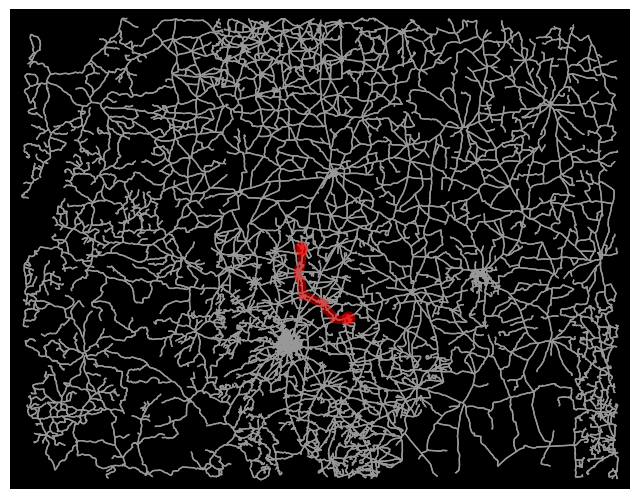

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [141]:
G = ox.add_edge_speeds(G) #Impute
G = ox.add_edge_travel_times(G) #Travel time

start = addresses_list[routes[0][0]].split(',')
end = addresses_list[routes[0][4]].split(',')

start_node = ox.distance.nearest_nodes(G, Y=float(start[0]), X=float(start[1]))
end_node = ox.distance.nearest_nodes(G, Y=float(end[0]), X=float(end[1]))

# Calculate the shortest path
route = nx.shortest_path(G, start_node, end_node, weight='travel_time')
#Plot the route and street networks
ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')

In [142]:
start = addresses_list[routes[0][0]].split(',')
end = addresses_list[routes[0][1]].split(',')
print(start, end)

G2 = ox.graph_from_point((float(start[0]), float(start[1])), dist=1000, network_type='drive')

# G2 = ox.add_edge_speeds(G2) #Impute
# G2 = ox.add_edge_travel_times(G2) #Travel time

start_node = ox.distance.nearest_nodes(G2, Y=float(start[0]), X=float(start[1]))
end_node = ox.distance.nearest_nodes(G2, Y=float(end[0]), X=float(end[1]))

# Calculate the shortest path
route = nx.shortest_path(G2, start_node, end_node)
#Plot the route and street networks
ox.plot_route_folium(G2, route, route_linewidth=6, node_size=0, bgcolor='k')

['23.375887349858058', '75.15751752653416'] ['23.687550388676396', '75.21434337666783']


<Axes: >

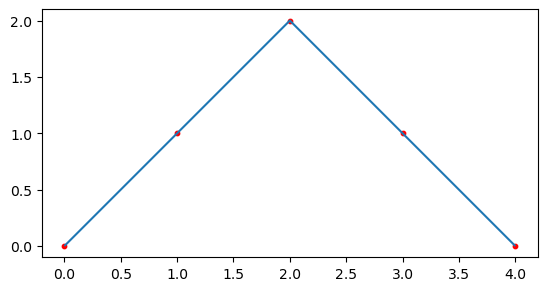

In [143]:
from shapely.geometry import LineString, MultiPoint, Point

# Define the coordinates of the route as a list of (lon, lat) tuples
coords = [(0, 0), (1, 1), (2, 2), (3, 1), (4, 0)]

# Create a LineString geometry from the coordinates
route = LineString(coords)

# Create a MultiPoint geometry from the coordinates
multipoint = MultiPoint([Point(x, y) for x, y in coords])

# Create a GeoDataFrame with the route as the geometry
gdf = gpd.GeoDataFrame(geometry=[route], crs='EPSG:4326')

# Plot the route and the points using geopandas
ax = gdf.plot()
gpd.GeoDataFrame(geometry=[multipoint]).plot(ax=ax, color='red', markersize=10)